# Learning rate/momentum schedules with pre-trained models
* Ignore training from scratch for now. Use only imagenet pre-trained models
* Use standard model like resnet50. Better model like DenseNet 169 just isn't good enough to justify the decreased batch size and higher iteration time.

The default to investigate will be resnet50 with CIFAR10

Try:
* Finding optimal learning rate given common momemtum initialization. 
* Find optimal momentum given a sensible learning rate schedule.
* Try optimizing both at the same time.


Later:
* Test on MNIST, CIFAR10, CIFAR100, ???
* Try different models (resnet 50, densenet 169, ???)
* Try different numbers of epochs until the test. Enough to get high accuracy, and much less than expected to give optimal.

Maybe:
* Look at how the learning rates evolve from a bad initialization to a sensible one (gif)
* look at how optimal learning rate schedule changes based on the momemtum used.


## Test out the pre-trained model and Training from scratch on CIFAR

In [1]:
import os
import sys
import glob
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

fast_ai_dir = '/media/rene/Data/fastai/'
sys.path.append(fast_ai_dir)

SEED = 101
np.random.seed(SEED)
from torchvision import datasets, models, transforms

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Add the src directory for functions
src_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'src')
print(src_dir)
sys.path.append(src_dir)

# import my functions:
from genetic import*

torch.cuda.set_device(1)
print(torch.cuda.is_available())
print(torch.cuda.current_device())

/media/rene/Data/learn-lr/src
True
1


### Reorder folders 
http://forums.fast.ai/t/not-a-directory-error-in-cifar10-exercise/13401

In [2]:
PATH = "/media/rene/Data/data/cifar10/"

In [14]:
# import os
# import glob
# import shutil
# classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# cwd = os.getcwd()
# train_path = PATH + '/train/'
# test_path = PATH + '/test/'
# sample_path = PATH + '/sample/'

# # go through classes and make a directory for each one
# for class_now in classes:
#     path_now = train_path + class_now
#     if not os.path.exists(path_now):
#         os.makedirs(path_now)
# # go through classes and match them with file names
# # file names are e.g. '123_frog.png' so glob picks out all the e.g. frog files
# for class_now in classes:
#     identifier = train_path + '*' + class_now + '.png'
#     class_files = glob.glob(identifier)
#     file_destination = train_path + class_now
#     # move all frog files to proper class directory
#     for file_to_move in class_files:
#         shutil.move(file_to_move, file_destination)

# # do all the same but now for the test data
# for class_now in classes:
#     path_now = test_path + class_now
#     if not os.path.exists(path_now):
#         os.makedirs(path_now)
# for class_now in classes:
#     identifier = test_path + '*' + class_now + '.png'
#     class_files = glob.glob(identifier)
#     file_destination = test_path + class_now
#     for file_to_move in class_files:
#         shutil.move(file_to_move, file_destination)


# def make_sample_dataset(data_loc, new_loc, ttv_folders, frac):
#     """ttv_folders are the names of test, train, valid folders. Assume already in fastai folder format"""   
#     for folder in ttv_folders:
#         classes = [name for name in os.listdir(os.path.join(data_loc, folder)) if os.path.isdir(os.path.join(data_loc, folder, name))]
#         # go through classes, make output directory, copy a sample of image to this
#         for class_name in classes:
#             curr_path = os.path.join(data_loc, folder, class_name)
#             out_path = os.path.join(new_loc, folder, class_name)
#             if not os.path.exists(out_path):
#                 os.makedirs(out_path)
                
#             files = glob.glob(curr_path + '/*.png')
#             sample_files = random.sample(files, int(len(files)*frac))
#             for file_to_copy in sample_files:
#                 shutil.copyfile(file_to_copy, os.path.join(new_loc, folder, class_name, file_to_copy.rsplit('/')[-1]))
                  
# new_loc = os.path.join(PATH, 'sample')
# ttv_folders = ['train', 'test']
# frac = .05
# make_sample_dataset(PATH, new_loc, ttv_folders, frac)

## Check Darknet (fastai) on CIFAR

Use a standard architecture from fastai (https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb) for consistency. Nothing special, just a good residual architecture.

Architecture Choices:
* Residual connections (obviously better)
* Leaky ReLU - Sometimes helps, so why not?
* ??? BatchNorm2d(nf, momentum=0.01) ???

In [3]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): 
        return x.add(self.conv2(self.conv1(x)))
#        return x.add_(self.conv2(self.conv1(x)))

class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        layers = [conv_layer(3, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x): return self.layers(x)

In [16]:
num_workers = 4
bs=256
sz=32
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [17]:
m = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=32)

In [18]:
lr = 1.3
learn = ConvLearner.from_model_data(m, data)
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4

In [19]:
print(torch.__version__)
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(20, 20, 0.95, 0.85))

0.3.1.post2


 19%|█▉        | 37/196 [00:08<00:35,  4.52it/s, loss=2.73]
epoch      trn_loss   val_loss   accuracy                   
    0      2.116278   5.893328   0.145     
    1      1.811555   2.475484   0.1729                     
    2      1.615913   2.726614   0.1724                     
    3      1.44142    2.047642   0.2936                     
    4      1.243913   1.807264   0.3747                     
    5      1.087812   1.185657   0.5766                     
    6      0.95191    1.376443   0.5022                      
    7      0.858742   1.233885   0.5778                      
    8      0.788671   1.021934   0.651                       
    9      0.72621    1.074404   0.6414                      
    10     0.7014     0.924746   0.6999                      
    11     0.662952   0.950845   0.6667                      
    12     0.62576    0.936544   0.6889                      
    13     0.580086   1.460393   0.5737                      
    14     0.565217   0.636019   0

[array([0.27822]), 0.9121]

epoch      trn_loss   val_loss   accuracy                    
    0      0.921993   1.593282   0.5677    
    1      0.676647   0.643562   0.77                        
    2      0.61068    0.610323   0.7865                      
    3      0.552512   0.53407    0.815                       
    4      0.467992   0.500855   0.8274                      



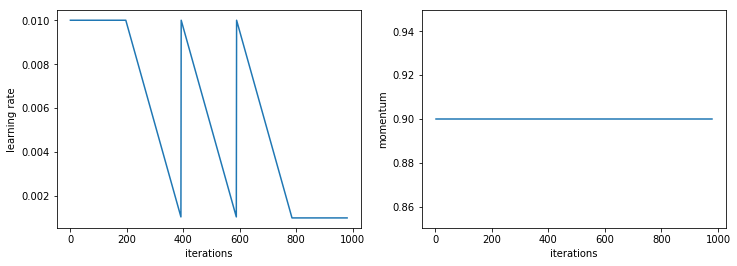

In [8]:
# %%capture output
data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

learn2 = ConvLearner.from_model_data(m, data)
learn2.crit = nn.CrossEntropyLoss()
learn2.metrics = [accuracy]

phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2), 
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = (1e-2,1e-3), lr_decay=DecayType.LINEAR),
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = (1e-2,1e-3), lr_decay=DecayType.LINEAR),
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = (1e-2,1e-3), lr_decay=DecayType.LINEAR),
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-3)]

learn2.fit_opt_sched(phases)
learn2.sched.plot_lr(show_text=False)

## Try 1 cycle

In [18]:
def phases_1cycle(cycle_len,lr,div,pct,max_mom,min_mom):
    tri_cyc = (1-pct/100) * cycle_len
    return [TrainingPhase(epochs=tri_cyc/2, opt_fn=optim.SGD, lr=(lr/div,lr), lr_decay=DecayType.LINEAR, 
                          momentum=(max_mom,min_mom), momentum_decay=DecayType.LINEAR),
           TrainingPhase(epochs=tri_cyc/2, opt_fn=optim.SGD, lr=(lr,lr/div), lr_decay=DecayType.LINEAR, 
                          momentum=(min_mom,max_mom), momentum_decay=DecayType.LINEAR),
           TrainingPhase(epochs=cycle_len-tri_cyc, opt_fn=optim.SGD, lr=(lr/div,lr/(100*div)), lr_decay=DecayType.LINEAR, 
                          momentum=max_mom)]

epoch      trn_loss   val_loss   accuracy                   
    0      1.491403   2.678981   0.1       
    1      1.187516   2.74842    0.2237                     
    2      0.996605   1.051909   0.6184                      
    3      0.851205   0.984126   0.6622                      
    4      0.753191   0.963182   0.6777                      
    5      0.678458   0.882305   0.7001                      
    6      0.606284   0.684817   0.7697                      
    7      0.561461   0.679993   0.7688                      
    8      0.527134   0.90337    0.7286                      
    9      0.5038     0.754078   0.7538                      
    10     0.452573   0.633484   0.7835                      
    11     0.426208   0.609193   0.8014                      
    12     0.387196   0.578991   0.8056                      
    13     0.366651   0.50027    0.8334                      
    14     0.338658   0.462992   0.8449                      
    15     0.311444   0.5338

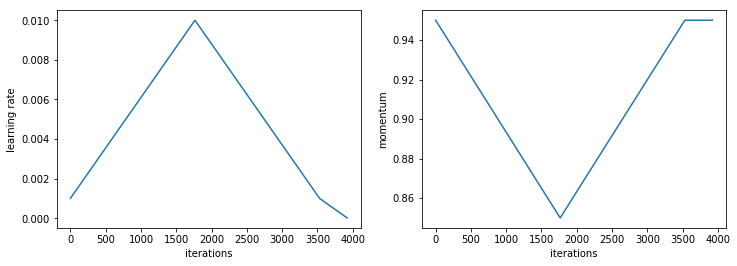

In [19]:
m = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=32)

data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)
learn = ConvLearner.from_model_data(m, data)
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]

learn.fit_opt_sched(phases_1cycle(20, 1e-2, 10, 10, 0.95, 0.85))
learn.sched.plot_lr(show_text=False)

## Check pre-trained ResNet on CIFAR 
* Use standard architecture (ResNet50)

In [ ]:
num_workers = 4
bs=64
sz=32
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [ ]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True,

In [ ]:
def run_genetic(data_loc, out_loc, generations, num_schedules, epochs, batch_size, momentum, kwargs):
    """Run the genetic algorithm on schedules for number of generations. Save best model at each generation and final best 5 models
    """

    # initialize schedules:
    population = create_population(num_schedules=num_schedules, epochs=epochs)

    # Using the same training split for all, create data loaders
    indexes = list(range(60000))
    random.shuffle(indexes)
    valid_frac = .2
    train_samples_index = indexes[int(valid_frac*len(indexes)):]
    valid_samples_index = indexes[0:int(valid_frac*len(indexes))]
    train_loader, valid_loader, test_loader = MNIST_data_loaders(data_loc, train_samples_index, valid_samples_index, kwargs, batch_size=batch_size)

    # Create network
    model = SmallNet()
    model.cuda()

    # Store the top schedule and accuracy (tuples) as elements in a list.
    history=[]

    # Evolve the generation.
    for i in range(generations):
        print('Running generation: ', i)
        pop_perf = model.get_population_perf(population, train_loader, valid_loader, test_loader, momentum)
        pop_perf = [x for x in sorted(pop_perf, key=lambda x: x[0], reverse=True)]
        history.append(pop_perf[0])

        # print average accuracy, best accuracy, and best schedule
        perf_only = [x[0] for x in pop_perf]
        avg = sum(perf_only)/len(perf_only)
        print('Avg acc: ', avg, 'best acc: ', pop_perf[0][0])
        print('Schedule: ',[ '%.5f' % elem for elem in pop_perf[0][1]])

        # Evolve
        population = evolve(pop_perf)

    # get final accuracy, and print the top 5 sorted
    pop_perf = model.get_population_perf(population, train_loader, valid_loader, test_loader, momentum)
    pop_perf = [x for x in sorted(pop_perf, key=lambda x: x[0], reverse=True)]

    # Print out the top 5 networks.
    print('Final Results: ', pop_perf[:5])

    # save history as a pickle file
    out_file = os.path.join(out_loc, 'evol_mnist_gener_'+str(generations)+'_numsch_'+str(epochs)+'_epochs_'+str(epochs))
    pickle.dump(history, open(out_file, 'wb'))

run_genetic(args.data_loc, args.out_loc, args.generations, args.num_schedules, args.epochs, args.batch_size, args.momentum, kwargs)
